# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import numpy as np
import pandas as pd
import pickle
import project_tests as t

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import accuracy_score, f1_score

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [3]:
user_articles = df.groupby('email')['article_id'].count()
user_articles.head()

email
0000b6387a0366322d7fbfc6434af145adf7fed1    13
001055fc0bb67f71e8fa17002342b256a30254cd     4
00148e4911c7e04eeff8def7bbbdaf1c59c2c621     3
001a852ecbd6cc12ab77a785efa137b2646505fe     6
001fc95b90da5c3cb12c501d201a915e4f093290     2
Name: article_id, dtype: int64

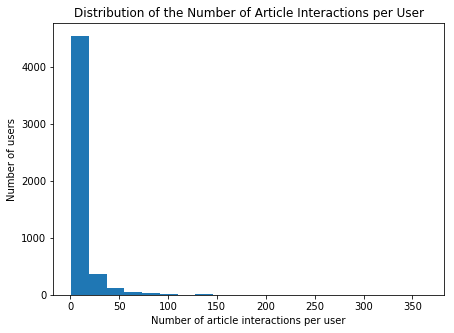

In [4]:
plt.figure(figsize=(7, 5));
plt.hist(user_articles,bins=20);
plt.xlabel("Number of article interactions per user");
plt.ylabel("Number of users");
plt.title("Distribution of the Number of Article Interactions per User");

In [5]:
# Fill in the median and maximum number of user_article interactios below

# 50% of individuals interact with ____ number of articles or fewer.
median_val = user_articles.median()

# The maximum number of user-article interactions by any 1 user is ______.
max_views_by_user = user_articles.max()

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [6]:
# Find and explore duplicate articles
df_content[df_content.duplicated(subset='article_id')]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [7]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset=['article_id'], keep='first', inplace=True)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [8]:
# The number of unique articles that have at least one interaction
df['article_id'].nunique()

714

In [9]:
# The number of unique articles on the IBM platform
df_content['article_id'].nunique()

1051

In [10]:
# The number of unique users
df['email'].nunique()

5148

In [11]:
# The number of user-article interactions
df.shape[0]

45993

In [12]:
# The number of unique articles that have at least one interaction
unique_articles = 714

# The number of unique articles on the IBM platform
total_articles = 1051

# The number of unique users
unique_users = 5148

# The number of user-article interactions
user_article_interactions = 45993

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [13]:
df['article_id'].value_counts().head()

1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
Name: article_id, dtype: int64

In [14]:
# The most viewed article in the dataset as a string with one value following the decimal 
most_viewed_article_id = '1429.0'

# The most viewed article in the dataset was viewed how many times?
max_views = 937

In [15]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [16]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [17]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = list(df.groupby(['article_id', 'title']).size()\
                        .reset_index(name='count').sort_values('count', ascending=False)[:n].title)
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    df_top_articles = df.groupby(['article_id', 'title']).size()\
                        .reset_index(name='count').sort_values('count', ascending=False)[:n]
    
    top_articles = list(df_top_articles['article_id'].astype(str))
 
    return top_articles # Return the top article ids

In [18]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [19]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [20]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''  
    # Drop duplicate rows and create rows & columns
    user_item = df.drop_duplicates().groupby(['user_id', 'article_id']).size().unstack()
    
    # Fill Nan to '0'
    user_item = user_item.fillna(0)
    
    # Convert float to int
    user_item = user_item.astype('int')
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)
user_item.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [22]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # Compute similarity of each user to the provided user
    user_similr = user_item.loc[user_id, :].dot(user_item.T)

    # Sort by similarity
    user_similr = user_similr.sort_values(ascending=False)     
   
    # Remove the own user's id
    most_similar_users = user_similr.loc[~(user_similr.index==user_id)].index.values.tolist()
       
    return most_similar_users # return a list of the users in order from most to least similar

In [23]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [24]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = df[df['article_id'].isin(article_ids)]['title'].drop_duplicates().unique()
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    user_idx = user_item.loc[user_id, :]
    article_ids = user_idx[user_idx == 1].index.values.astype('str').tolist()
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Find similar users
    most_similar_users = find_similar_users(user_id)
    
    # Get articles the user read
    user_article_ids = set(get_user_articles(user_id)[0])
    
    # Save recommendations
    recs = []
    for similar_user in most_similar_users:
        neighb_article_ids = set(get_user_articles(similar_user)[0])
        recs += list(set(neighb_article_ids) - set(user_article_ids))
        if len(recs) > m:
            break
    
    recs = recs[:m]
    return recs # return your recommendations for this user_id

In [25]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

array(['deploy your python model as a restful api',
       'visualize data with the matplotlib library',
       'pixieapp for outlier detection',
       'model bike sharing data with spss',
       'modeling energy usage in new york city',
       'deep learning with data science experience',
       'spark-based machine learning tools for capturing word meanings',
       'airbnb data for analytics: vancouver listings',
       'this week in data science (may 2, 2017)',
       'using bigdl in dsx for deep learning on spark'], dtype=object)

In [26]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [27]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Initialize    
    colName = ['neighbor_id', 'similarity', 'num_interactions']
    neighbors_df  = pd.DataFrame(columns= colName)
    
    art_count = df.groupby('user_id').count()
    
    
    for id in user_item.index.values:
        if id != user_id:
            neighbor_id = id
            # Getting user-to-user similarity number
            similarity = user_item[user_item.index == user_id].dot(user_item.loc[id].T).values[0]
            # Number of interactions for user-to-article
            num_interactions = user_item.loc[id].values.sum()
            neighbors_df.loc[neighbor_id] = [neighbor_id, similarity, num_interactions]
    
    neighbors_df['similarity'] = neighbors_df['similarity'].astype('int')
    neighbors_df['neighbor_id'] = neighbors_df['neighbor_id'].astype('int')
    neighbors_df = neighbors_df.sort_values(by = ['similarity', 'neighbor_id'], ascending = [False, True])
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    recs = []
    i = 1
    most_similar_users = get_top_sorted_users(user_id)
    list_article_read = get_user_articles(user_id)[0]
    while len(recs) < m:
    # list of the articles read by the i similar user
        list_similar_read = get_user_articles(i)[0]
        
    # order them by most interactions   
        df_by_article_ids = df[df['article_id'].isin(list_similar_read)].groupby('article_id').count()
        df_by_article_ids_sorted = df_by_article_ids.sort_values('title',ascending=False)['title']
    
        top_articles_ids = []
    
        for i in range(0,df_by_article_ids_sorted.shape[0]):
            top_articles_ids.append(df_by_article_ids_sorted.index[i])   
    # identify the articles that where not already read by the user
        not_read = list(set(top_articles_ids) - set(list_article_read))
    # identify the articles that where not already recommended to the user
        to_recommend = list(set(not_read) - set(recs))
    # add the new recommendations to the recommendation list
        recs.extend(to_recommend)
        recs = list(set(recs))
    # iteration through the next similar user
        i +=1
    # break the loop if whe already iterated through all the similar users
        if i > len(most_similar_users):
            break
        else :
            pass
    
    # add random article to the recommandation list if < m or cut if too many article
    if len(recs)<m :
        recs.extend(get_top_article_ids(m-len(recs)))
        recs = recs[:m]
    if len(recs) == m:
        recs = recs
    elif len(recs) > m:
        recs = recs[:m]
    
    rec_names = get_article_names(recs)
    return recs, rec_names

In [28]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[768.0, 390.0, 268.0, 1293.0, 910.0, 525.0, 1170.0, 1427.0, 1429.0, 1430.0]

The top 10 recommendations for user 20 are the following article names:
['using pixiedust for fast, flexible, and easier data analysis and experimentation'
 'use deep learning for image classification'
 'apache spark lab, part 1: basic concepts'
 'use xgboost, scikit-learn & ibm watson machine learning apis'
 'finding optimal locations of new store using decision optimization'
 'sector correlations shiny app'
 'new shiny cheat sheet and video tutorial'
 'python if statements explained (python for data science basics #4)'
 'working with ibm cloud object storage in python'
 'introducing ibm watson studio ']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [29]:
### Tests with a dictionary of results

# Find the user that is most similar to user 1 
user1_most_sim = get_top_sorted_users(1).iloc[0].neighbor_id

# Find the 10th most similar user to user 131
user131_10th_sim = get_top_sorted_users(131).iloc[9].neighbor_id 

In [30]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Response:**
>Almost all of the above functions relies on user similarity, so we could not give the new user a very robust recommendation except for providing him some top best articles, although this probably would not be a very good recommendation. Instead, we can have a content based approach, this way instead of recommending articles based on other similar user we offer him articles based on what that user likes.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [31]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 

new_user_recs = get_top_article_ids(10) # Your recommendations here

In [32]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [33]:
import re
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

In [34]:
# uncomment if not installed
# nltk.download('punkt')
# nltk.download('wordnet')

In [35]:
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [36]:
# check null values
df_content.isnull().mean()

doc_body           0.013321
doc_description    0.002854
doc_full_name      0.000000
doc_status         0.000000
article_id         0.000000
dtype: float64

In [37]:
def tokenize(text):
    """    
    INPUT:
    text - (string) the message to be clean and tokenized
    
    OUTPUT:
    clean_tokens - (list) the list containing the cleaned and tokenized words of
                    the message
    
    DESCRIPTION:
    Clean and tokenize text for modeling. It will replace all non-
    numbers and non-alphabets with a blank space. Next, it will
    split the sentence into word tokens and lemmatized them with Nltk's 
    WordNetLemmatizer(), first using noun as part of speech, then verb.
    Finally, the word tokens will be stemmed with Nltk's PorterStemmer.
    """
    # replace all non-alphabets and non-numbers with blank space
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    # Tokenize words
    tokens = word_tokenize(text)
    
    # instantiate lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # instantiate stemmer
    stemmer = PorterStemmer()
    
    clean_tokens = []
    for tok in tokens:
        # lemmtize token using noun as part of speech
        clean_tok = lemmatizer.lemmatize(tok)
        # lemmtize token using verb as part of speech
        clean_tok = lemmatizer.lemmatize(clean_tok, pos='v')
        # stem token
        clean_tok = stemmer.stem(clean_tok)
        # strip whitespace and append clean token to array
        clean_tokens.append(clean_tok.strip())
        
    return clean_tokens


def vectorize_title(df_cont):
    '''  
    INPUT:
    df_content - (dataframe) dataframe containing doc_body, doc_description, doc_full_name,
                 doc_status, article_id

    OUTPUT:
    df_content_new - (dataframe) df_content concatenated with Tfidf vectors representing 
                     the titles of the articles
    
    DESCRIPTION:
    Convert title of documents into a Tfidf vector. Returns a dataframe containing article_id, Tfidf 
    vector representation of document titles
    '''
    
    tf = TfidfVectorizer(ngram_range=(1,3), tokenizer=tokenize, min_df=0.01, max_df=0.99)
    tf_df = tf.fit_transform(df_cont['doc_full_name'])
    
    tf_df = pd.DataFrame(tf_df.toarray(), columns=tf.get_feature_names())
    
    df_content_new = pd.concat([df_cont, tf_df],axis=1)
    
    return df_content_new


def vectorize_description(df_cont):
    '''
    INPUT:
    df_content - (dataframe) dataframe containing doc_body, doc_description, doc_full_name, 
                 doc_status, article_id

    OUTPUT:
    df_content_new - (dataframe) df_content concatenated with Tfidf vectors representing the 
                     description of the articles
    
    DESCRIPTION:
    Convert description of documents into a Tfidf vector. Returns a dataframe containing article_id, Tfidf 
    vector representation of document description
    '''
    
    tf = TfidfVectorizer(ngram_range=(1,3), tokenizer=tokenize, min_df=0.01, max_df=0.99)
    tf_df = tf.fit_transform(df_cont['doc_description'])
    
    tf_df = pd.DataFrame(tf_df.toarray(), columns=tf.get_feature_names())
    
    df_content_new = pd.concat([df_cont, tf_df],axis=1)
    
    return df_content_new

In [38]:
# drop all rows with na values for simpilicity sake
df_content_new = df_content.dropna().reset_index(drop=True)

# vectorize title
df_content_new = vectorize_title(df_content_new)
df_content_new.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id,0,1,10,2,2016,...,web,week,week in,week in data,what,whi,with,work,you,your
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.351239,0.000000,0.0,0.000000
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.492917,0.0,0.371547
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.292998,0.300784,0.300784,0.0,0.0,0.000000,0.000000,0.0,0.000000
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.321150
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000


In [39]:
# vectorize description
df_content_new = vectorize_description(df_content_new)
df_content_new.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id,0,1,10,2,2016,...,you how,you how to,you ll,you need,you re,you to,your,your data,your databas,your own
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
# drop unnecessary columns
df_content_new.drop(['doc_body', 'doc_description', 'doc_full_name', 'doc_status'], axis=1, inplace=True)
df_content_new.head()

,article_id,0,1,10,2,2016,2017,3,5,a,...,you how,you how to,you ll,you need,you re,you to,your,your data,your databas,your own
0,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.276331,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.341678,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
def reduce_dimensionality(df_cont, n_features):
    """
    INPUT:
    df_cont - (dataframe ) df_content with Tfidf vector representations of article titles 
              and/or description
    n_features - (int) number of dimensions for PCA to reduce to
    
    OUTPUT:
    df_content_new - (dataframe) df_cont with original Tfidf vectors replaced with 
                     reduced PCA components
    
    DESCRIPTION:
    Reduce Tfidf vectors of article titles and descriptions with PCA to a smaller dimension as specified.
    """
    df_cont_col = df_cont.columns.values
    
    col_to_drop = df_cont_col[1:]
    
    pca = PCA(n_components=n_features)
    
    X_pca = pca.fit_transform(df_cont.iloc[:,1:])
    X_pca_df = pd.DataFrame(X_pca, columns=['PCA%i' % i for i in range(n_features)], index=df_cont.index)
    
    df_cont.drop(col_to_drop, axis=1, inplace=True)
    
    df_content_new = pd.concat([df_cont, X_pca_df],axis=1)
    
    return df_content_new

In [42]:
# reduce dimensionality of TFIDF vectors
df_content_pca = reduce_dimensionality(df_content_new, 100)
df_content_pca.head()

,article_id,PCA0,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,...,PCA90,PCA91,PCA92,PCA93,PCA94,PCA95,PCA96,PCA97,PCA98,PCA99
0,0,-0.057658,-0.040052,-0.066514,0.056270,-0.124909,0.031431,-0.181677,-0.099400,-0.075392,...,-0.025050,-0.102639,0.006815,-0.135710,-0.070900,0.070394,0.045129,-0.044685,-0.031825,0.050246
1,1,0.123403,-0.011333,0.163637,0.048436,0.293457,0.004665,-0.048697,0.243542,-0.031466,...,-0.024353,-0.160062,-0.082155,0.073168,-0.094947,0.113203,-0.033091,0.110377,-0.078128,-0.106404
2,2,1.263529,-0.011614,-0.028466,-0.106319,-0.162880,0.003593,-0.006838,0.024758,-0.008424,...,0.002692,0.006381,0.013664,0.017004,0.000013,-0.015925,0.022018,0.019262,0.002078,0.019294
3,3,-0.061927,-0.062979,0.051711,-0.052104,0.112761,-0.215518,-0.016348,-0.130712,-0.115593,...,0.044384,0.014516,0.078392,-0.019806,-0.107696,0.059668,0.007802,0.007997,0.081828,-0.049939
4,4,0.023111,-0.074399,0.006582,0.541552,0.036827,0.056913,0.091323,-0.170446,0.109743,...,-0.068026,0.099955,0.009409,-0.019512,0.058766,0.068215,0.031741,-0.023735,-0.049637,0.094690


In [43]:
def compute_similarity(article_id, df_cont=df_content_pca):
    """
    INPUT:
    article_id - (int) the id of input article
    df_cont - (dataframe) dataframe containing article_id and pca components of TFIDF vector representations
              of article titles and description
    
    OUTPUT:
    neighbors_df - (dataframe) dataframe containing article ids of neighboring articles ranked by how similar they are
                   to the input article
    
    DESCRIPTIONS:
    Ranks neighboring articles on how similar they are to the input articles based on the euclidean
    distance between the pca components of articles. The pca components are the TFIDF vector 
    representations of article titles and description reduced to a lower dimension
    """
    articles_idx = np.array(df_cont['article_id'])
    
    article_pca = np.array(df_cont[df_cont['article_id']==article_id].iloc[:,1:])[0]
    
    eucl_dist_list = []
    
    for row, col in df_cont.iterrows():
        neigh_pca = np.array(col[1:])
        # compute euclidean distance
        eucl_dist = np.linalg.norm(article_pca-neigh_pca)
        eucl_dist_list.append(eucl_dist)
        
    eucl_dist_series = pd.Series(eucl_dist_list, index=articles_idx)    

    neighbors_df = pd.DataFrame({'neighbor_id':articles_idx,\
                                 'similarity':eucl_dist_series}).set_index('neighbor_id')
    
    # remove current user from dataframe
    neighbors_df.drop([article_id], inplace=True)
    
    # sort by similarity and then by number of interactions
    neighbors_df.sort_values(['similarity'], ascending=True, inplace=True)
    
    return neighbors_df

In [44]:
# test. Get 10 most similar article to article 1
neighbors_df = compute_similarity(1)
neighbors_df.head(10)

,similarity
neighbor_id,
8,0.925357
92,0.941058
766,0.961882
599,0.979200
126,0.984383
109,0.990292
185,0.995072
632,0.997324
876,1.000719


In [45]:
df_content[df_content['article_id']==1]

,doc_body,doc_description,doc_full_name,doc_status,article_id
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1


In [46]:
df_content[df_content['article_id']==8]

,doc_body,doc_description,doc_full_name,doc_status,article_id
8,* Host\r\n * Competitions\r\n * Datasets\r\n *...,Kaggle is your home for data science. Learn ne...,Data Science Bowl 2017,Live,8


In [47]:
# test. Get 10 most similar article to article 1000
neighbors_df = compute_similarity(1000)
neighbors_df.head(10)

,similarity
neighbor_id,
297,0.662047
607,0.672059
905,0.686326
884,0.843387
928,0.955650
967,0.971696
51,1.027330
903,1.032420
495,1.045352


In [48]:
df_content[df_content['article_id']==1000]

,doc_body,doc_description,doc_full_name,doc_status,article_id
1005,developerWorks Premium An all-access pass to b...,Most large-scale commercial and social website...,Recommender systems: Approaches & algorithms,Live,1000


In [49]:
df_content[df_content['article_id']==297]

,doc_body,doc_description,doc_full_name,doc_status,article_id
297,* Free 7-Day Crash Course\r\n * Blog\r\n * Mas...,Which modern dimensionality reduction algorith...,Dimensionality Reduction Algorithms,Live,297


In [50]:
def get_article_names_df_content(articles_ids, df_cont=df_content):
    '''
    INPUT:
    articles_ids - (list) list of article ids
    df_cont - (dataframe) dataframe containing information for all articles
              available on IBM Watson Platform
                
    OUTPUT:
    articles_names - (list) titles of articles
    
    DESCRIPTION:
    Return article names from df_content. This will return names of
    new articles that users have not interacted with before.
    '''
    articles_names = []
    
    for art_id in articles_ids:
        art_name = df_cont[df_cont['article_id']==art_id]['doc_full_name'].values[0]
        articles_names.append(art_name)
        
    return articles_names
    
def make_content_recs(article_id, df_cont_pca=df_content_pca, m=10):
    '''
    INPUT:
    article_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations by article id
    rec_names - (list) a list of recommendations by article title
    
    DESCRIPTION:
    Loops through the articles based on closeness to the input article_id. 
    Closeness is determined by how small the euclidean distance is between
    the pca components of tfidf vector respresentation of both document title
    and document description
    '''
    neighbors_df = compute_similarity(article_id, df_cont_pca)
    
    rec_articles_ids = np.array(neighbors_df.index.values)[:m]
    
    rec_articles_names = get_article_names_df_content(rec_articles_ids)
    
    return rec_articles_ids, rec_articles_names

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**
>This content based recommendation system takes an input article and finds other articles that have similar names and description. It does this by converting article names and descriptions into TFIDF vectors seperately. Both TFIDF vectors, one for title and the other for description, will be concatenenated. The system then reduces the dimensions of the combined TFIDF vector to 100 dimensions using PCA. The euclidean distance between two articles' reduced TFIDF vector will be be used to determine how similar the articles are. The more similar the articles, the smaller the euclidean distance between the two.<br><br>$$ \sqrt{(x_1 - y_1)^2 + ... + (x_{100} - y_{100})^2} $$<br>
where X is the reduced TFIDF vector of the input article, and Y is the reduced TFIDF vector of a neighboring article.<br>There are a couple of other improvements that can be made to the system. In addition to using the name and description, we can compare the bodies of the articles. Furthermore, other type of text representations can be use instead of TFIDF vectorizations. These includes word embedding techniques such as Word2Vec or GloVe. 

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Making recommendation for a brand new user**

In [51]:
# for a brand new user, we will recommend the popular articles
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


**Make a recommendations for a user who only has interacted with article id '1427.0'**

In [52]:
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [53]:
df_content.tail()

,doc_body,doc_description,doc_full_name,doc_status,article_id
1051,PouchDB-find is a new API and syntax that allo...,PouchDB uses MapReduce as its default search m...,A look under the covers of PouchDB-find,Live,1046
1052,We compare discriminative and generative learn...,We compare discriminative and generative learn...,A comparison of logistic regression and naive ...,Live,1047
1053,"Essays about data, building products and boots...",In order to demystify some of the magic behind...,What I Learned Implementing a Classifier from ...,Live,1048
1054,NaN,Learn how to use IBM dashDB as data store for ...,Use dashDB with Spark,Live,1049
1055,Homepage Follow Sign in / Sign up Homepage * H...,Once you get used to developing in a Notebook ...,"Jupyter Notebooks with Scala, Python, or R Ker...",Live,1050


In [54]:
df_content.query('article_id == 1427').head()

,doc_body,doc_description,doc_full_name,doc_status,article_id


_Note: This content-based recommendation system uses data from df-content, and df-content seems to have different article ids as df. Hence article id '1427' does not seem to exist in df-content, so I made recommendations based on 2 other articles instead: article id '1' and article id '1000'._

In [55]:
# recommend articles similar to article 1
article_id = 1
rec_articles_ids, rec_articles_names = make_content_recs(article_id)
print("Name of article id {} : {}".format(str(article_id), get_article_names_df_content([article_id])[0]))
print("\nRecommended articles ids:")
print(rec_articles_ids)
print("\nRecommended articles names:")
print(rec_articles_names)

Name of article id 1 : Communicating data science: A guide to presenting your work

Recommended articles ids:
[  8  92 766 599 126 109 185 632 876 847]

Recommended articles names:
['Data Science Bowl 2017', '9 Mistakes to Avoid When Starting Your Career in Data Science', 'Making data science a team sport', 'Random forest interpretation – conditional feature contributions', 'RethinkDB Joinery', 'TensorFlow Quick Tips', 'Location Tracker', 'Hyperparameter Optimization: Sven Hafeneger', 'Statistical Bias Types explained', 'Navigating NoSQL']


In [56]:
# recommend articles similar to article 1
article_id = 1000
rec_articles_ids, rec_articles_names = make_content_recs(article_id)
print("Name of article id {} : {}".format(str(article_id), get_article_names_df_content([article_id])[0]))
print("\nRecommended articles ids:")
print(rec_articles_ids)
print("\nRecommended articles names:")
print(rec_articles_names)

Name of article id 1000 : Recommender systems: Approaches & algorithms

Recommended articles ids:
[297 607 905 884 928 967  51 903 495 379]

Recommended articles names:
['Dimensionality Reduction Algorithms', 'Recommendation System Algorithms – Stats and Bots', 'The Random Forest Algorithm ', 'Don’t overlook simpler techniques and algorithms', 'Time Series Anomaly Detection Algorithms – Stats and Bots', 'ML Algorithm != Learning Machine', 'Modern Machine Learning Algorithms', 'An Attempt to Understand Boosting Algorithm(s)', 'Top 10 Machine Learning Algorithms for Beginners', 'Data Structures Related to Machine Learning Algorithms']


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [57]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [58]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [59]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item_matrix, full_matrices=False) # use the built in to get the three matrices

In [60]:
u.shape, s.shape, vt.shape

((5149, 714), (714,), (714, 714))

**Response:**
>SVD implementation is different because here we dont have any missing values, if on the hand, there were any missing values, SVD could not be done and funkSVD would be the way to go.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

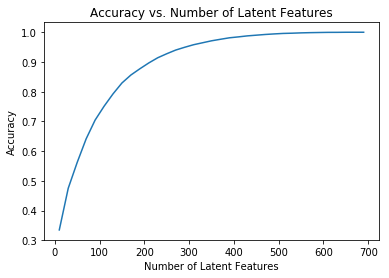

In [61]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [62]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [63]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = user_item_test.index.values
    test_arts = user_item_test.columns.values
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [64]:
# How many users can we make predictions for in the test set?
train_idx = user_item_train.index.values
num_test_users_w_pred = len(np.intersect1d(test_idx, train_idx))
num_test_users_w_pred

20

In [65]:
# How many users in the test set are we not able to make predictions for because of the cold start problem?
num_test_users_wo_pred = len(test_idx) - num_test_users_w_pred
num_test_users_wo_pred

662

In [66]:
# How many articles can we make predictions for in the test set?
train_art_idx =  user_item_train.columns.values
test_art_idx =  user_item_test.columns.values

num_test_art_w_pred = len(np.intersect1d(test_art_idx, train_art_idx))
num_test_art_w_pred

574

In [67]:
# How many movies in the test set are we not able to make predictions for because of the cold start problem?
num_test_art_wo_pred = len(test_art_idx) - num_test_art_w_pred
num_test_art_wo_pred

0

In [68]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [69]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices=False) # fit svd similar to above then use the cells below
u_train.shape, s_train.shape, vt_train.shape

((4487, 714), (714,), (714, 714))

In [70]:
# find subset of u_train that are in test
u_test = u_train[user_item_train.index.isin(test_idx),:]
u_test.shape

(20, 714)

In [71]:
# find subset of vt_train that are in test
vt_test = vt_train[:,user_item_train.columns.isin(test_arts)]
vt_test.shape

(714, 574)

In [72]:
# get subset of user_item_test that we can obtain predictions
test_users_w_pred_idx = np.intersect1d(test_idx, train_idx)
#test_users_w_pred_idx
user_item_test_subset = user_item_test[user_item_test.index.isin(test_users_w_pred_idx)]
user_item_test_subset.shape

(20, 574)

In [73]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

num_latent_feats = np.arange(10,700+10,20)

train_accuracy_list = []
test_accuracy_list = []
train_f1_list = []
test_f1_list = []

for k in num_latent_feats:
    new_u_train, new_s_train, new_vt_train = u_train[:,:k], np.diag(s_train[:k]), vt_train[:k,:]
    new_u_test, new_vt_test = u_test[:,:k], vt_test[:k,:]
    
    user_item_train_pred = np.around(np.dot(np.dot(new_u_train, new_s_train), new_vt_train))
    user_item_test_pred = np.around(np.dot(np.dot(new_u_test, new_s_train), new_vt_test))
    
    # clip predictions to 1 and 1 range
    # since we are only predicting whether user will interact with articles
    # which is a binary outcome
    user_item_train_pred = np.clip(user_item_train_pred, 0, 1)
    user_item_test_pred = np.clip(user_item_test_pred, 0, 1)
    
    # get accuracy score for this iteration
    acc_train = accuracy_score(np.array(user_item_train).flatten(), user_item_train_pred.flatten())
    acc_test = accuracy_score(np.array(user_item_test_subset).flatten(), user_item_test_pred.flatten())
    #print(acc_train), print(acc_test)
    
    # get f1 score for this iteration
    f1_train = f1_score(np.array(user_item_train).flatten(), user_item_train_pred.flatten())
    f1_test = f1_score(np.array(user_item_test_subset).flatten(), user_item_test_pred.flatten())
    #print(f1_train), print(f1_test)
    
    train_accuracy_list.append(acc_train)
    test_accuracy_list.append(acc_test)
    
    train_f1_list.append(f1_train)
    test_f1_list.append(f1_test)

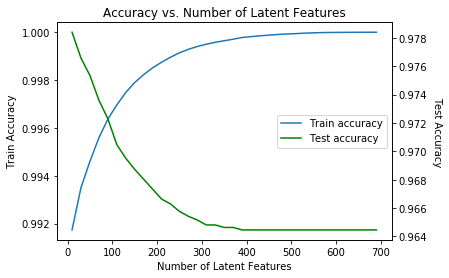

In [74]:
fig, ax1 = plt.subplots();
ax2 = ax1.twinx();

ax1.plot(num_latent_feats, train_accuracy_list, label="Train accuracy");
ax2.plot(num_latent_feats, test_accuracy_list, color='green', label="Test accuracy");

handle1, label1 = ax1.get_legend_handles_labels();
handle2, label2 = ax2.get_legend_handles_labels();

ax1.legend(handle1+handle2, label1+label2, loc='center right');

ax1.set_title('Accuracy vs. Number of Latent Features');

ax1.set_xlabel('Number of Latent Features');
ax1.set_ylabel('Train Accuracy');
ax2.set_ylabel('Test Accuracy', rotation=270, labelpad=15);

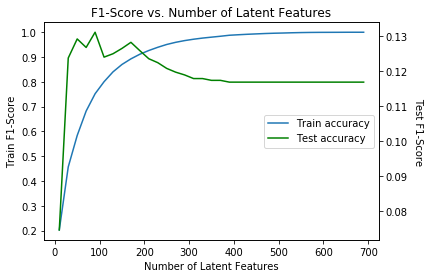

In [75]:
fig, ax1 = plt.subplots();
ax2 = ax1.twinx();

ax1.plot(num_latent_feats, train_f1_list, label="Train accuracy");
ax2.plot(num_latent_feats, test_f1_list, color='green', label="Test accuracy");

handle1, label1 = ax1.get_legend_handles_labels();
handle2, label2 = ax2.get_legend_handles_labels();

ax1.legend(handle1+handle2, label1+label2, loc='center right');

ax1.set_title('F1-Score vs. Number of Latent Features');

ax1.set_xlabel('Number of Latent Features');
ax1.set_ylabel('Train F1-Score');
ax2.set_ylabel('Test F1-Score', rotation=270, labelpad=15);

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Response:**
>The classes are extremely imbalanced since most articles were not read by users. Hence, there are a far greater proportion of labels with class 0 as compared to class 1. Overfitting might have occurred since the model can get a fairly good accuracy by predicting class 0 for all data points. This is probably the reason why accuracy score was far higher than the f1 score on the test set. To reduce the amount of overfitting, we can perhaps reduce the amount of latent features used, up-sample the number of data points in the minority class, use cross-validation, or simply get more data. As we can observe from the f1-scores plot above, decreasing the number of latent features does improve the test f1-score slightly. However, the improvement is not substantial.<br><br>The ideal number of latent features to use is approximately 90 features. This yielded the best test f1-score, at approximately 0.13. In our case, f1-score is preferred over accuracy since the classes are imbalanced.<br><br>
Since there were only 20 users that can be found in both the training and test data, the test results might not be an accurate representation for how well our recommendations are doing. Hence, we should seek to obtain more data.<br><br>
A better metric to use for our recommendation will be article ratings, as opposed to the current metric that tracks whether the user has interacted with the article. It is hard to determine if a user did not view an article because the user did not like it, or simply because the user did not have the opportunity to read the article. There is always the possibility that our user might like an article if he or she actually views it. Hence, the low f1-score for the test data does not necessarily suggest that the recommendations were subpar.<br><br>
Since our platform is online, we could test how well our recommendations are doing through an A/B test. We could assign half of our users into a control group and these users will use the old recommendation system. The other half could be assigned to the experimental group, where they will use the new recommendation system. If we are not collecting article ratings, then a good metric to use for this test will be the mean/median number of article interactions per user. We will observe if the new system improve the number of article interactions. If we are collecting article ratings, we could observe whether the new recommendation system improves the mean/median of article ratings as compared to the old system.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [76]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0